# TP3 — EDA → Imputation → ACP (80%) → KMeans — HealthMind


**Roadmap (simple) :**  
1) **Comprendre** la data (colonnes, types, nulls) et **visualiser** les valeurs manquantes.  
2) **Remplacer réellement** les valeurs manquantes (`df_clean`).  
3) **ACP (80%)** : scree plot, cercle, biplot.  
4) **(Option)** KMeans pour segments.  
5) **Conclusions** claires.


## 0) Compréhension & visualisation des données

Shape: (3500, 14)

Colonnes:
- User_ID
- Age
- Gender
- Education_Level
- Employment_Status
- Work_Hours_Week
- Sleep_Hours_Night
- Exercise_Freq_Week
- Social_Support
- GAD-7_Score
- PHQ-9_Score
- Stress_Level_Scale
- Coping_Mechanism
- Risk_Level


,dtype
User_ID,int64
Age,int64
Gender,object
Education_Level,object
Employment_Status,object
Work_Hours_Week,float64
Sleep_Hours_Night,float64
Exercise_Freq_Week,float64
Social_Support,object
GAD-7_Score,int64


,n_unique
User_ID,3500
Sleep_Hours_Night,3206
Work_Hours_Week,1997
Age,52
PHQ-9_Score,28
GAD-7_Score,22
Stress_Level_Scale,8
Exercise_Freq_Week,7
Coping_Mechanism,7
Employment_Status,5


,missing_count,missing_%
Education_Level,245,7.0
Work_Hours_Week,245,7.0
Sleep_Hours_Night,245,7.0
Exercise_Freq_Week,245,7.0
Stress_Level_Scale,245,7.0
Coping_Mechanism,245,7.0
User_ID,0,0.0
Age,0,0.0
Gender,0,0.0
Employment_Status,0,0.0


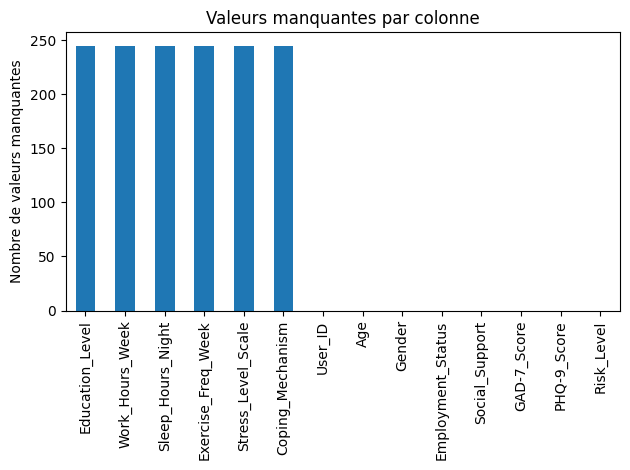

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Mental_Health_Data_3500.csv')
print("Shape:", df.shape)

print("\nColonnes:")
for c in df.columns:
    print("-", c)

dtypes = df.dtypes.astype(str).to_frame("dtype")
display(dtypes)

uniq = df.nunique().sort_values(ascending=False).to_frame("n_unique")
display(uniq)

missing_count = df.isna().sum().sort_values(ascending=False)
missing_ratio = (df.isna().mean()*100).round(2).sort_values(ascending=False)
missing_table = pd.DataFrame({"missing_count": missing_count, "missing_%": missing_ratio})
display(missing_table)

plt.figure()
missing_count.plot(kind="bar")
plt.ylabel("Nombre de valeurs manquantes")
plt.title("Valeurs manquantes par colonne")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



**On fait quoi ici ?**  
- On liste **noms de colonnes**, **types**, **valeurs uniques**.  
- On calcule et **on trace** les valeurs manquantes par colonne.


## 1) Imputation réelle (df_clean)

In [2]:

from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

df_num = pd.DataFrame(num_imp.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
df_cat = pd.DataFrame(cat_imp.fit_transform(df[cat_cols]), columns=cat_cols, index=df.index)

df_clean = pd.concat([df_num, df_cat], axis=1)[df.columns]
print("Nb total de valeurs manquantes après imputation:", int(df_clean.isna().sum().sum()))
df_clean.head()


Nb total de valeurs manquantes après imputation: 0


,User_ID,Age,Gender,Education_Level,Employment_Status,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,Social_Support,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale,Coping_Mechanism,Risk_Level
0,1001.0,35.0,Female,University,Employed,50.790616,3.573649,4.0,Low,7.0,22.0,8.0,Socializing,Medium
1,1002.0,28.0,Male,University,Unemployed,0.000000,6.127009,1.0,Low,8.0,3.0,4.0,Work,Low
2,1003.0,37.0,Other,University,Unemployed,0.000000,5.571812,2.0,Medium,6.0,12.0,4.0,Gaming,Medium
3,1004.0,48.0,Female,University,Self-employed,80.000000,6.721314,2.0,Low,9.0,14.0,5.0,Gaming,Medium
4,1005.0,27.0,Male,University,Employed,49.670909,7.754259,3.0,Low,7.0,17.0,8.0,Isolation,Medium



**Pourquoi cette étape ?**  
- Pour avoir une **version sans trous** de la data (utile pour des exports/analyses).  
- Ensuite, pour la **modélisation**, on préfère un **Pipeline** (ci-dessous) qui répète ces étapes proprement.


## 2) Pipeline de prétraitement pour l’ACP

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

num_cols_pca = df.select_dtypes(include=["int64","float64"]).columns.tolist()
for tgt in ["Risk_Level", "Stress_Level_Scale"]:
    if tgt in num_cols_pca:
        num_cols_pca.remove(tgt)
cat_cols_pca = [c for c in df.columns if c not in num_cols_pca]

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", RobustScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols_pca),
    ("cat", cat_pipe, cat_cols_pca)
])
preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['User_ID', 'Age', 'Work_Hours_Week',
                                  'Sleep_Hours_Night', 'Exercise_Freq_Week',
                                  'GAD-7_Score', 'PHQ-9_Score']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Education_Level',
                                  'Employment_Status', 'Social_Support',
                                  'Stress_Level_Scale', 'Coping_Mechanism',
                                  'Risk_Level'])])


**Explications simples :**  
- **Imputer** = remplir les trous ; **Scaler** = mettre à la même échelle ; **OneHot** = transformer les catégories en 0/1.  
- `ColumnTransformer` applique le bon traitement à chaque groupe de colonnes.


## 3) ACP (objectif 80% de variance cumulée)

Variance expliquée (%): [8.11 7.87 7.46 5.99 5.59 4.88 4.69 4.65 4.42 4.37]
Variance cumulée (%): [ 8.11 15.98 23.44 29.44 35.03 39.91 44.61 49.26 53.67 58.04]
Axes gardés (≈80%): 10


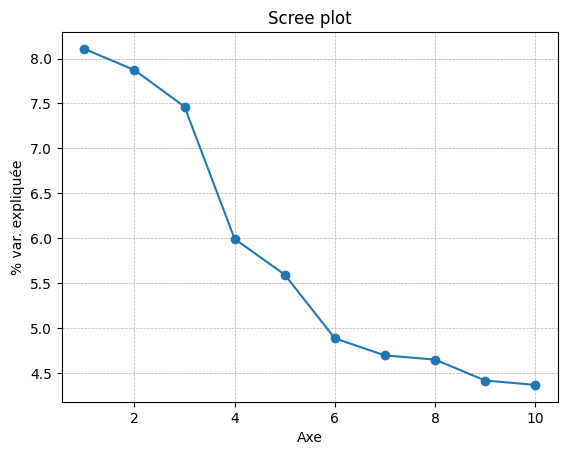

In [4]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca_probe = Pipeline([("prep", preprocess), ("pca", PCA(n_components=10, random_state=42))])
Z = pca_probe.fit_transform(df)
pca_obj = pca_probe.named_steps["pca"]
evr = pca_obj.explained_variance_ratio_
cum = evr.cumsum()

print("Variance expliquée (%):", np.round(evr*100, 2))
print("Variance cumulée (%):", np.round(cum*100, 2))

n_keep = int(np.argmax(cum >= 0.80) + 1) if np.any(cum >= 0.80) else len(evr)
n_keep = max(2, n_keep)
print("Axes gardés (≈80%):", n_keep)

plt.figure()
plt.plot(range(1, len(evr)+1), evr*100, marker="o")
plt.xlabel("Axe"); plt.ylabel("% var. expliquée"); plt.title("Scree plot")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


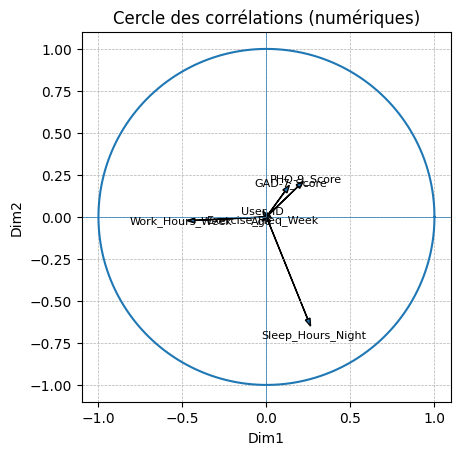

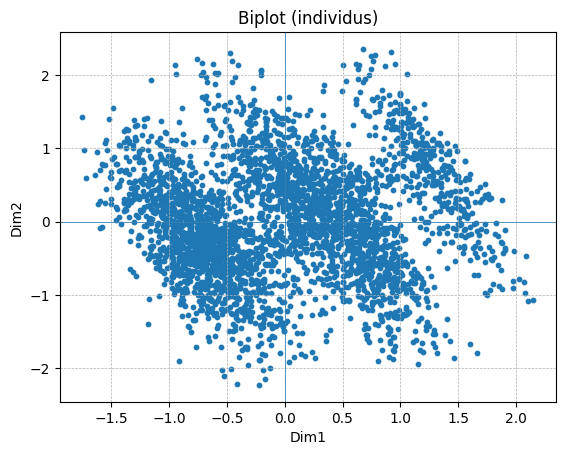

In [5]:

# Refit PCA & visualisations
pca_final = Pipeline([("prep", preprocess), ("pca", PCA(n_components=n_keep, random_state=42))])
scores = pca_final.fit_transform(df)
pca_k = pca_final.named_steps["pca"]

feat_names = pca_final.named_steps["prep"].get_feature_names_out()
components = pca_k.components_
ev = pca_k.explained_variance_
loadings = components.T * np.sqrt(ev)

import re
num_mask = [name.startswith("num__") for name in feat_names]
num_names = [re.sub(r"^num__", "", n) for n, m in zip(feat_names, num_mask) if m]
num_load = loadings[num_mask, :]

# Cercle Dim1-Dim2
theta = np.linspace(0, 2*np.pi, 400)
plt.figure()
plt.plot(np.cos(theta), np.sin(theta))
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
for i, var in enumerate(num_names):
    x, y = num_load[i, 0], num_load[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.08, y*1.08, var, ha="center", va="center", fontsize=8)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Cercle des corrélations (numériques)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Biplot
plt.figure()
plt.scatter(scores[:,0], scores[:,1], s=10)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Biplot (individus)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


## 4) (Option) KMeans sur l'espace ACP — choix de k par silhouette

Silhouette: [(2, 0.13356230492405163), (3, 0.13710674679601098), (4, 0.14019527238229126), (5, 0.14208841014365634), (6, 0.12289642728013314), (7, 0.12768708223949546)]
Meilleur k = 5 (silhouette = 0.142)


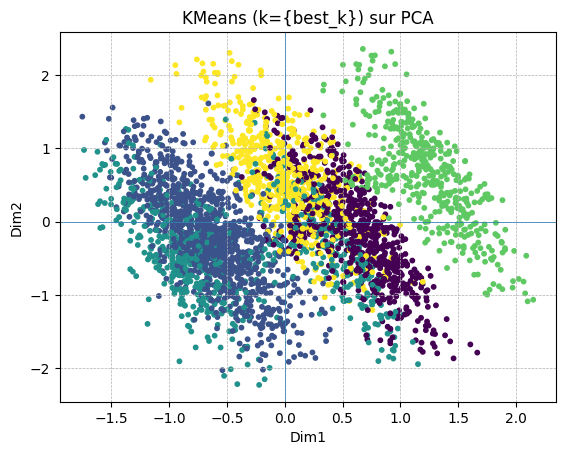

__cluster__
0     703
1    1092
2     661
3     441
4     603
Name: count, dtype: int64

,User_ID,Age,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,GAD-7_Score,PHQ-9_Score
__cluster__,,,,,,,
0,2743.12,30.20,9.15,6.52,2.95,9.89,12.77
1,2766.72,31.26,46.96,6.48,3.12,10.23,12.58
2,2735.83,30.63,31.84,6.46,3.03,4.61,4.70
3,2756.83,30.77,9.38,6.44,2.88,15.39,21.26
4,2741.19,30.85,46.33,6.41,2.96,15.17,21.55


In [6]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(scores)
    sil.append((k, silhouette_score(scores, labels)))

best_k, best_s = max(sil, key=lambda x: x[1])
print("Silhouette:", sil)
print(f"Meilleur k = {best_k} (silhouette = {best_s:.3f})")

km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(scores)
labels = km.labels_

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(scores[:,0], scores[:,1], c=labels, s=10)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title(f"KMeans (k={{best_k}}) sur PCA")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Profilage simple
df_prof = df.copy()
df_prof["__cluster__"] = labels
display(df_prof["__cluster__"].value_counts().sort_index())
num_cols_profile = df.select_dtypes(include=["int64","float64"]).columns.tolist()
for tgt in ["Risk_Level", "Stress_Level_Scale"]:
    if tgt in num_cols_profile:
        num_cols_profile.remove(tgt)
display(df_prof.groupby("__cluster__")[num_cols_profile].mean().round(2))



## 5) Conclusions (claires et simples)

- Dataset : **3500 lignes**, **14 colonnes**.  
- Les **valeurs manquantes** ont été **visualisées** puis **remplacées réellement** (médiane/mode) dans `df_clean`.  
- **ACP** : on garde le nombre d’axes nécessaire pour atteindre **80%** de variance cumulée (pas 85%).  
  - Les deux premiers axes expliquent environ **16.0%** (Dim1 ≈ **8.1%**, Dim2 ≈ **7.9%**).  
- **(Option)** Clustering KMeans : choisir **k** via **silhouette**, visualiser les groupes et **décrire** leurs profils.

**Prochaine étape** : ajouter un **modèle de classification** (RF / GB), mesurer **Recall/F1**, et générer des **recommandations** basées sur les facteurs clés.
